In [34]:
from omegaconf import OmegaConf
from torch.utils.data import DataLoader
from EventStream.data.dataset_polars import Dataset
from EventStream.evaluation.general_generative_evaluation import ESTForTrajectoryGeneration
from EventStream.data.pytorch_dataset import PytorchDataset
from EventStream.transformer.config import StructuredTransformerConfig
from EventStream.transformer.lightning_modules.generative_modeling import PretrainConfig, ESTForGenerativeSequenceModelingLM
from EventStream.transformer.conditionally_independent_model import CIPPTForGenerativeSequenceModeling 
from EventStream.transformer.lightning_modules.fine_tuning_dev import FinetuneConfig
from EventStream.transformer.model_output import get_event_types
from safetensors.torch import load_file
import torch
import hydra
import numpy as np

import matplotlib.pyplot as plt

In [35]:
from omegaconf import OmegaConf
from hydra import initialize, compose

# Step into the config directory
with initialize(version_base=None, config_path="../configs/synthetic_0/"):  # path to your config directory
    cfg = compose(config_name="finetune")  # your .yaml file name (no .yaml extension)

if not isinstance(cfg, FinetuneConfig):
    cfg = hydra.utils.instantiate(cfg, _convert_="object")

Loading data_config from /home/filip-marcus/ESGPT_new/EventStreamGPT/pretrain/synthetic_0/data_config.json
reloaded_data_config PytorchDatasetConfig(save_dir=PosixPath('/home/filip-marcus/ESGPT_new/EventStreamGPT/data/processed/synthetic_0'), max_seq_len=20, min_seq_len=13, seq_padding_side='right', subsequence_sampling_strategy='random', train_subset_size='FULL', train_subset_seed=1, task_df_name='task_df_synthetic_event_label', do_include_subsequence_indices=False, do_include_subject_id=False, do_include_start_time_min=False)
Overwriting save_dir in data_config from /home/filip-marcus/ESGPT_new/EventStreamGPT/data/processed/synthetic_0 to /home/filip-marcus/ESGPT_new/EventStreamGPT/data/processed/synthetic_0
Overwriting max_seq_len in data_config from 20 to 20
Overwriting seq_padding_side in data_config from right to right
Overwriting subsequence_sampling_strategy in data_config from random to to_end
Overwriting train_subset_size in data_config from FULL to FULL
Overwriting train_sub

In [95]:
print(type(cfg))

model = CIPPTForGenerativeSequenceModeling(
        config=cfg.config
    )
    

initial_weights = {name: param.clone() for name, param in model.named_parameters()}


model.from_pretrained(
    cfg.pretrained_weights_fp
)
# # Load pretrained weights
# checkpoint = load_file(cfg.pretrained_weights_fp / 'model.safetensors')
# model.load_state_dict(checkpoint)


# Compare parameters
total_params = 0
params_changed = 0
params_unchanged = 0
for name, param in model.named_parameters():
    total_params+=1
    if not torch.equal(initial_weights[name], param):
        # print(f"{name} has been updated with pretrained weights.")
        params_changed +=1
    else:
        params_unchanged+=1
        # print(f"{name} remains unchanged!")

print(f"Total parameters: {total_params} | Updated params: {params_changed} | Unchanged params: {params_unchanged}")
model.eval()

for param in model.parameters():
    param.requires_grad = False

train_pyd = PytorchDataset(config=cfg.data_config, split="train")    

train_dataloader = DataLoader(
    train_pyd, batch_size=32, collate_fn=train_pyd.collate, shuffle=False
)  

dataloader_iter = iter(train_dataloader)

batch1=next(dataloader_iter)
batch2=next(dataloader_iter)
encoded1 = model.encoder(batch1,
                                  use_cache = None,
                                  output_attentions=False,
                                  output_hidden_states=True,
                                  return_dict=True)
        
        
last_hidden_state1 = encoded1.last_hidden_state
print(last_hidden_state1.shape)

encoded2 = model.encoder(batch2,
                                  use_cache = None,
                                  output_attentions=False,
                                  output_hidden_states=True,
                                  return_dict=True)
        
        
last_hidden_state2 = encoded2.last_hidden_state


logits_task_event =(model.output_layer.TaskEventCLassificationLayer(last_hidden_state1))

print(logits_task_event.shape)

<class 'EventStream.transformer.lightning_modules.fine_tuning_dev.FinetuneConfig'>
torch.float32
torch.float32
Total parameters: 126 | Updated params: 0 | Unchanged params: 126
Re-loading task data for task_df_synthetic_event_label from /home/filip-marcus/ESGPT_new/EventStreamGPT/data/processed/synthetic_0/DL_reps/for_task/task_df_synthetic_event_label:
/home/filip-marcus/ESGPT_new/EventStreamGPT/data/processed/synthetic_0/DL_reps/for_task/task_df_synthetic_event_label/train_0.parquet
torch.Size([32, 19, 180])
torch.Size([32, 19, 1])


In [140]:
logits_mean05 = logits_task_event - torch.mean(logits_task_event) + 0.5

print(torch.mean(logits_mean05))



tensor(0.5000)


In [137]:
logits_task_event_1 = logits_task_event[:,1] +(0.5-logits_mean)
logits_task_event_0 = logits_task_event[:,0] +(0.5-logits_mean)

In [66]:
logits_flat1 = last_hidden_state1.detach().cpu().reshape(-1, last_hidden_state1.shape[-1])
logits_flat2 = last_hidden_state2.detach().cpu().reshape(-1, last_hidden_state2.shape[-1])

In [67]:
from sklearn.decomposition import PCA
print(logits_2d1.shape)
pca = PCA(n_components=1)
logits_2d1 = pca.fit_transform(logits_flat1)  # shape: [640, 2]
logits_2d2 = pca.fit_transform(logits_flat2)  # shape: [640, 2]

(608, 1)


In [138]:
from sklearn.cluster import KMeans

n_clusters = 2 # or whatever you expect
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters1 = kmeans.fit_predict(logits_task_event.squeeze(-1))
clusters2 = kmeans.fit_predict(logits_2d2)

(608, 1)


/tmp/ipykernel_2792626/3431904671.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter( range(len(logits_task_event.flatten())),logits_task_event.flatten(), cmap="tab10", s=10)


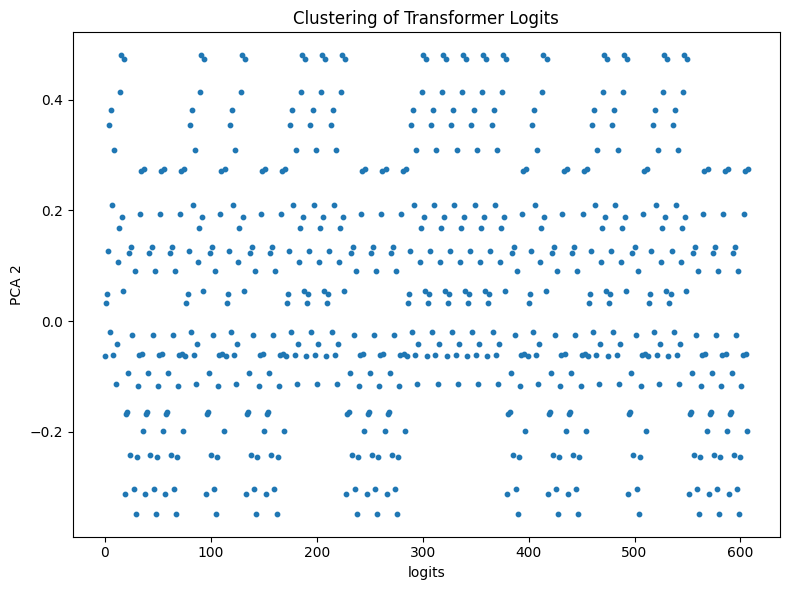

In [141]:
# Plot
print(logits_2d1.shape)
plt.figure(figsize=(8, 6))
scatter = plt.scatter( range(len(logits_task_event.flatten())),logits_task_event.flatten(), cmap="tab10", s=10)
plt.title("Clustering of Transformer Logits")
plt.xlabel("logits")
plt.ylabel("PCA 2")

plt.tight_layout()
plt.show()

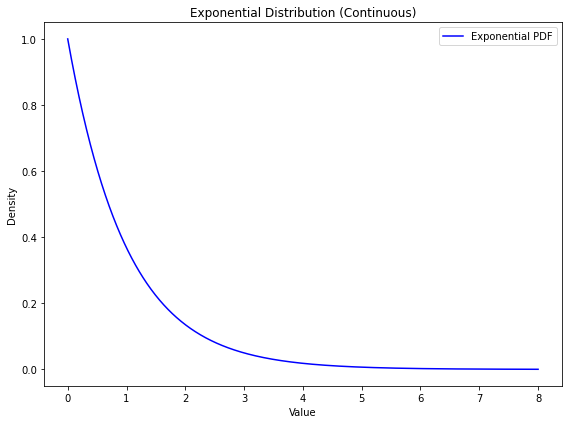

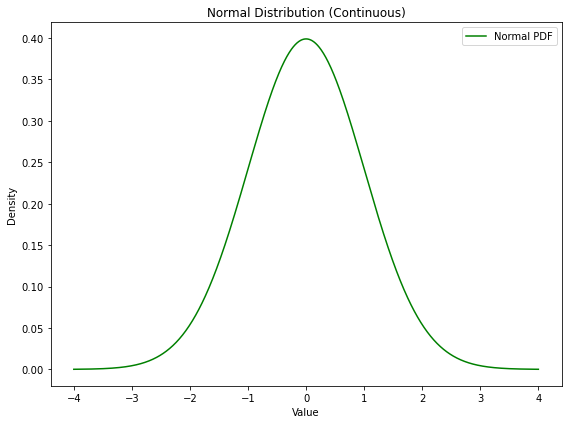

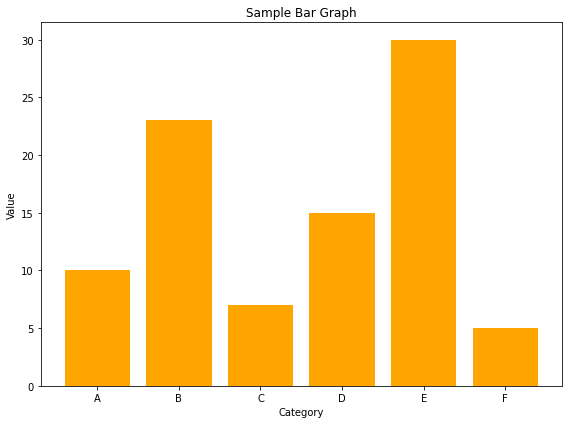

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Exponential Distribution (continuous)
lambda_param = 1.0  # rate parameter
x_exp = np.linspace(0, 8, 1000)
y_exp = lambda_param * np.exp(-lambda_param * x_exp)

plt.figure(figsize=(8, 6))
plt.plot(x_exp, y_exp, color='blue', label='Exponential PDF')
plt.title("Exponential Distribution (Continuous)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# Normal Distribution (continuous)
mu = 0
sigma = 1
x_norm = np.linspace(-4, 4, 1000)
y_norm = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_norm - mu)/sigma)**2)

plt.figure(figsize=(8, 6))
plt.plot(x_norm, y_norm, color='green', label='Normal PDF')
plt.title("Normal Distribution (Continuous)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# Bar Graph (discrete)
categories = ['A', 'B', 'C', 'D','E','F']
values = [10, 23, 7, 15, 30, 5]

plt.figure(figsize=(8, 6))
plt.bar(categories, values, color='orange')
plt.title("Sample Bar Graph")
plt.xlabel("Category")
plt.ylabel("Value")
plt.tight_layout()
plt.show()